# Income Predictions - Logistic Regression (Timothy Manolias)

### The following program predicts whether an individual makes less than or greater than 50K dollars a year, based on 1994 U.S. census data and a logistic regression model.

## Imports Libraries and Data

In [1]:
'''Loads Libraries.'''

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statistics
import warnings
import random

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

In [2]:
'''Loads Data and Sets Seed.'''

train_data = pd.read_csv('Data/income_train.csv')
test_data = pd.read_csv('Data/income_test.csv')
random.seed(100)

train_data.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


## Data Preprocessing

#### The data contains entries with a value of `?`. I executed a different version of this notebook for three datasets to evaluate the `?` values:

- A dataset which keeps the '?' values as they originally appear. 
- A dataset which replaces all '?' values with the mode (most often) value of that column.
- A dataset which drops all rows with a '?' entry.

Over 5% of the data contains a column value of `?`. After executing the three versions of this notebook, **keeping in the values as they originally appear allows for the best performance**. Therefore, preserving this data as opposed to dropping 5% of the data will result in the most optimal result going forward.

#### Converts Dependent Variable (income) to Dummy Variables

In [3]:
# train_data
train_dummies = pd.get_dummies(train_data['income'])
if train_data['income'][1] not in [0, 1]:
    train_data = pd.concat((train_data, train_dummies['>50K']), axis=1)
    del train_data['income']
    train_data = train_data.rename(columns={">50K": "income"})

# test_data
test_dummies = pd.get_dummies(test_data['income'])
if test_data['income'][1] not in [0, 1]:
    test_data = pd.concat((test_data, test_dummies['>50K']), axis=1)
    del test_data['income']
    test_data = test_data.rename(columns={">50K": "income"})        

## Exploratory Data Analysis

#### Histograms of Numerical Features

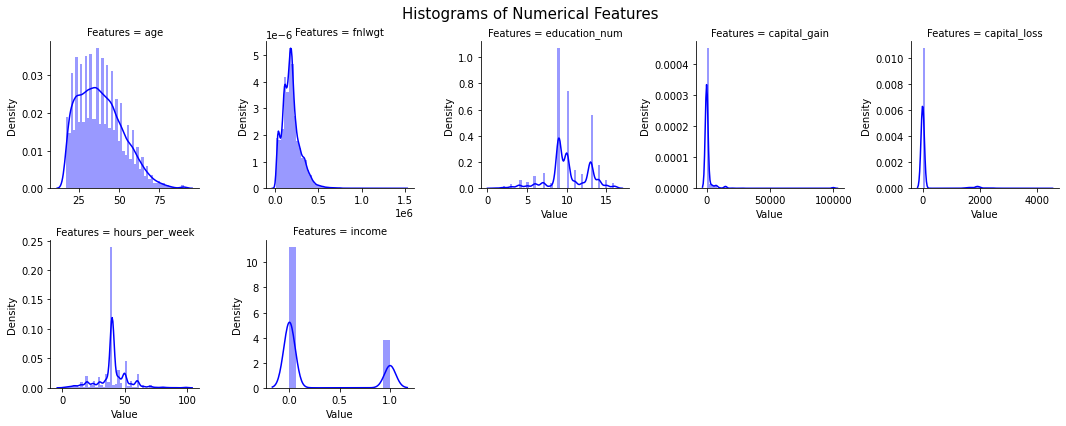

In [4]:
warnings.simplefilter('ignore', UserWarning)
warnings.simplefilter('ignore', FutureWarning)

numeric_features = train_data.select_dtypes(exclude=['object', 'bool'])
numeric_features_stack = numeric_features.stack().reset_index().rename(columns = {'level_1': 'Features', 0: 'Value'})

grid = sns.FacetGrid(data=numeric_features_stack, col="Features", col_wrap=5, sharex=False, sharey=False)
grid = grid.map(sns.distplot, 'Value', color='blue')

plt.subplots_adjust(top=0.9)
plt.suptitle('Histograms of Numerical Features', size=15);

**Evaluation of Histograms:**

- The distribution of `age` produces the most 'normal' distribution compared to the other numeric features.
- Most people within this dataset have a `highschool education` level or `college education` level (indicated by levels 9 & 10 in education_num).
- The `income` distribution indicates that there are many more people who make <=50K each year.
- Most people tend to work around `40 hours_per_week`.
- The `capital_gain` and `capital_loss` features are highly right-skewed. The capital_gain range is also significantly greater than the capital_loss range.

#### Correlation Matrix

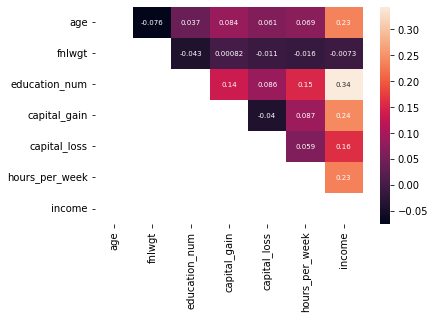

In [5]:
corr_cols = [i for i in numeric_features.columns]
lower_corr_triangle = np.tril(train_data[corr_cols].corr())
sns.heatmap(train_data[corr_cols].corr(), annot=True, mask=lower_corr_triangle, annot_kws={'fontsize': 7});

According to the correlation matrix listed above, **none of the features are highly correlated**. We therefore do not have to account for multicollinearity.

#### Bar Charts

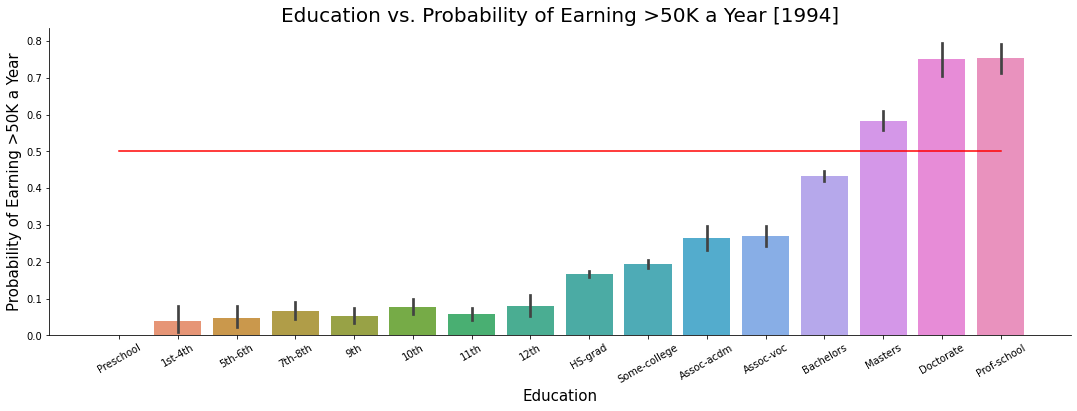

In [6]:
'''Plots  ">50K Income Proportion by Education and Gender"  Bar Chart.'''

x_axis_order = ['Preschool', '1st-4th', '5th-6th', '7th-8th', '9th', '10th', '11th', '12th', 'HS-grad', 'Some-college',
                'Assoc-acdm', 'Assoc-voc', 'Bachelors', 'Masters', 'Doctorate', 'Prof-school']

# Plots education vs. income graph
ax = sns.catplot(x="education", y="income", kind="bar", data=train_data, aspect=3, order=x_axis_order)
ax.set_xticklabels(rotation=30)

# Plots line where 50% of group makes >50K
x_coords, y_coords = [0,15], [0.5, 0.5]
plt.plot(x_coords, y_coords, 'r')

# Alters title and labels
plt.title('Education vs. Probability of Earning >50K a Year [1994]', size=20)
plt.ylabel('Probability of Earning >50K a Year', size=15)
plt.xlabel('Education', size=15);

- 50,000 dollars in 1994 is worth about 88,700 dollars in 2021

**Evaluation of 'Education vs. Income' Plot:**

- There seems to be an increase in the probability of making >50K a year as education level increases (after high school).
- One can expect a salary >50K when pursuing a Master's Degree

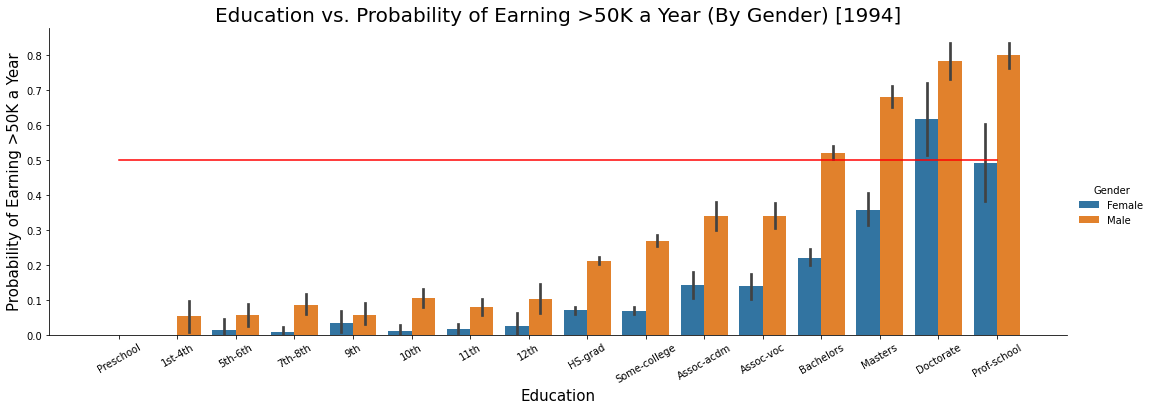

In [7]:
'''Plots  "Education vs. Income by Gender"  Bar Chart.'''

ax = sns.catplot(x="education", y="income", hue="sex", kind="bar", data=train_data, aspect=3, order=x_axis_order)
ax.set_xticklabels(rotation=30)

# Plots line where 50% of group makes >50K
x_coords, y_coords = [0,15], [0.5, 0.5]
plt.plot(x_coords, y_coords, 'r')

# Alters title and labels
plt.title('Education vs. Probability of Earning >50K a Year (By Gender) [1994]', size=20)
plt.ylabel('Probability of Earning >50K a Year', size=15)
plt.xlabel('Education', size=15)
ax._legend.set_title('Gender');

- 50,000 dollars in 1994 is worth about 88,700 dollars in 2021

**Evaluation of 'Education vs. Income by Gender' Plot:**

- There is a clear **gap in the probability of making >50K between men and women**.
- For **men**, atleast a **Bachelor's degree** is needed to expect **>50K salary each year**.
- For **women**, atleast a **Doctorate** is needed to expect **>50K salary each year**.

## Data Preprocessing (Continued)

In [8]:
'''Splits Data Into Dependent & Independent Variables.'''

# Splits train_data into X and y
train_data_X = train_data.drop(['income'], axis=1)
train_data_y = train_data[['income']]

# Splits test_data into X and y
test_data_X = test_data.drop(['income'], axis=1)
test_data_y = test_data[['income']]

In [9]:
'''Standardizes Continuous Features.'''

# Gets continuous variables
contin_cols = ['age', 'fnlwgt', 'education_num', 'capital_gain', 'capital_loss', 'hours_per_week']
contin_train = train_data_X[contin_cols]
contin_test = test_data_X[contin_cols]

# Performs standardization
sc = StandardScaler()
for col in contin_cols:
    # X_train
    temp_train = np.array(contin_train[col]).reshape(-1, 1)
    train_data_X[col] = sc.fit_transform(temp_train)
    
    # X_test
    temp_test = np.array(contin_test[col]).reshape(-1, 1)
    test_data_X[col] = sc.fit_transform(temp_test)

In [10]:
'''Converts Categorical Variables into Dummy Variables.'''

categ_cols = ['workclass', 'education', 'marital_status', 'occupation',
              'relationship', 'race', 'sex', 'native_country']

categ_train = pd.get_dummies(train_data_X[categ_cols])
categ_test = pd.get_dummies(test_data_X[categ_cols])

# Replaces old categorical columns with encoded columns
if categ_cols[0] in train_data_X.columns:
    train_data_X = train_data_X.drop(categ_cols, axis=1)
    train_data_X = pd.concat((train_data_X, categ_train), axis=1)
    
    test_data_X = test_data_X.drop(categ_cols, axis=1)
    test_data_X = pd.concat((test_data_X, categ_test), axis=1)

In [11]:
'''Adds in One-Hot Encoded Variables to Both Train and Tests Sets.'''

# Adds columns from test set
for col in test_data_X.columns:
    if col not in train_data_X.columns:
        train_data_X[col] = 0
        
# Adds columns from train set
for col in train_data_X.columns:
    if col not in test_data.columns:
        test_data_X[col] = 0

## Logistic Regression

In [12]:
'''Builds Logistic Model.'''

# Splits Data into train and validation sets
X_train, y_train = train_data_X.iloc[:2800,:],  train_data_y.iloc[:2800,:]
X_val, y_val = train_data_X.iloc[2800:,:],  train_data_y.iloc[2800:,:]

# Fits logistic regression model
mod = LogisticRegression(max_iter=1000)
mod.fit(X_train, y_train.values.ravel());

#### Creates Precision, Recall & Accuracy Functions to Evaluate Performance

In [13]:
def precision(y, y_preds):
    '''Returns precision, which is TP/(TP+FP).'''
    
    tp, fp = 0,  0
    for i in range(len(y_preds)):
        if y_preds[i] == 1:
            if y[i] == 1:
                tp += 1
            else:
                fp += 1
    
    return tp / (tp+fp) if tp+fp > 0 else 0

In [14]:
def recall(y, y_preds):
    '''Returns recall, which is TP/(TP+FN).'''

    tp, fn = 0,  0
    for i in range(len(y_preds)):
        if y_preds[i] == 1 and y[i] == 1:
            tp += 1
        elif y[i] == 1 and y_preds[i] == 0:
            fn += 1
                
    return tp / (tp+fn)

In [15]:
def accuracy(y, y_preds):
    '''Returns accuracy, which is (TP+TN)/(TP+FP+FN+TN).'''

    tp, tn, fp, fn = 0, 0, 0, 0
    
    for i in range(len(y_preds)):
        if y_preds[i] == 1 and y[i] == 1:
            tp += 1
        elif y_preds[i] == 1 and y[i] == 0:
            fp += 1
        elif y_preds[i] == 0 and y[i] == 1:
            fn += 1
        elif y_preds[i] == 0 and y[i] == 0:
            tn += 1
                
    return (tp + tn) / (tp + fp + fn + tn)

#### Predicts Output for Validation Set

In [16]:
def threshold_pred(pred_probs, threshold_level=.465): # Optimal default based on evaluation of 200 threshold values
    '''Returns New Predicted Value Based on Threshold value.'''

    new_predictions = []
    for pred in pred_probs:
        if pred[1] >= threshold_level:
            new_predictions.append(1)
        else:
            new_predictions.append(0)
            
    return new_predictions

In [17]:
'''Evaluates Validation Set Predictions.'''

y_pred = threshold_pred(mod.predict_proba(X_val))
y_val = np.array([i[0] for i in y_val.values.tolist()])

# Uses predictions to calculate accuracy, precision, recall
print(f'Precision: {precision(y_val, y_pred):.5f}')
print(f'Recall:    {recall(y_val, y_pred):.5f}')
print(f'Accuracy:  {accuracy(y_val, y_pred):.5f}')

Precision: 0.41452
Recall:    0.90723
Accuracy:  0.73056


#### ROC Curve

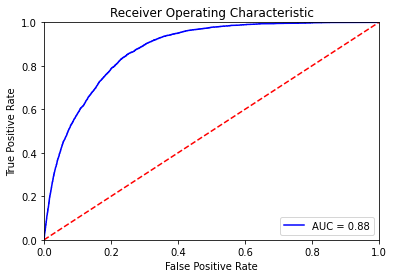

In [18]:
from sklearn.metrics import roc_curve
import sklearn.metrics as metrics

y_probs = mod.predict_proba(X_val)[:,1]
fpr, tpr, thresholds = metrics.roc_curve(y_val, y_probs, pos_label=1)
roc_auc = metrics.auc(fpr, tpr)

# Plots AUC graph
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Tuning Hyperparameters

In [19]:
def tune_logistic_model(c, p, X_train, y_train):
    '''Builds logistic regression model based on given hyperparameters.'''

    return LogisticRegression(C=c, penalty=p, solver='liblinear').fit(X_train, y_train.values.ravel())

In [20]:
def prediction_results(mod, y_val):
    '''Prints precision, recall & accuracy values, based on logistic model's predictions.'''
    
    y_pred = threshold_pred(mod.predict_proba(X_val))
    
    # Prints accuracy, precision & recall
    print(f'Precision: {precision(y_val, y_pred):.5f}')
    print(f'Recall:    {recall(y_val, y_pred):.5f}')
    print(f'Accuracy:  {accuracy(y_val, y_pred):.5f}')

#### **Model 1**: Builds a logistic regression model with hyperparameter **'C' set to 0.1** and **penalty set to 'l1'**.

In [21]:
mod1 = tune_logistic_model(0.1, 'l1', X_train, y_train)
prediction_results(mod1, y_val)

Precision: 0.35643
Recall:    0.95450
Accuracy:  0.65315


#### **Model 2**: Builds a logistic regression model with **hyperparameter 'C' set to 0.5** and **penalty set to 'l1'**.

In [22]:
mod2 = tune_logistic_model(0.5, 'l1', X_train, y_train)
prediction_results(mod2, y_val)

Precision: 0.41382
Recall:    0.91251
Accuracy:  0.72940


#### **Model 3**: Builds a logistic regression model with hyperparameter **'C' set to 0.1** and **penalty set to 'l2'**.

In [23]:
mod3 = tune_logistic_model(0.1, 'l2', X_train, y_train)
prediction_results(mod3, y_val)

Precision: 0.35988
Recall:    0.95669
Accuracy:  0.65784


#### **Model 4**: Builds a logistic regression model with hyperparameter **'C' set to 0.5** and **penalty set to 'l2'**.

In [24]:
mod4 = tune_logistic_model(0.5, 'l2', X_train, y_train)
prediction_results(mod4, y_val)

Precision: 0.40092
Recall:    0.92240
Accuracy:  0.71453


#### Best Model Out of the 4 Models Listed Above:

**Model 2**, with hyperparameter 'C' set to 0.5 and penalty set to 'l1', yields higher precision and accuracy values. Although model 2 has a slighty lower recall value than the other models, model 2's accuracy and precision values outweigh the slight decrease in recall compared to the other models. Therefore, **model 2 is the best model.**

## Test Set Predictions

In [25]:
'''Makes Predictions on test_data using Logistic Regression and Optimal Hyperparameters.'''

# Sorts columns and builds model
train_data_X = train_data_X.sort_index(axis=1)
test_data_X = test_data_X.sort_index(axis=1)
final_mod = mod2

# Predictions on test_data
test_pred = threshold_pred(final_mod.predict_proba(test_data_X))
test_val = np.array([i[0] for i in test_data_y.values.tolist()])

# Prints performance
print(f'Precision: {precision(test_val, test_pred):.5f}')
print(f'Recall:    {recall(test_val, test_pred):.5f}')
print(f'Accuracy:  {accuracy(test_val, test_pred):.5f}')

Precision: 0.30000
Recall:    0.49603
Accuracy:  0.68145


## Results and Evaluation

In [26]:
train_vs_test = {'Test Results' : {'Precision': precision(test_val, test_pred),
                                   'Recall'   : recall(test_val, test_pred),
                                   'Accuracy' : accuracy(test_val, test_pred)}}

pd.DataFrame(train_vs_test)

,Test Results
Accuracy,0.681451
Precision,0.300000
Recall,0.496025


Based on the results above, the model mis-labeled many >50K entries as <=50K entries.

The recall performance may be a result of overfitting. In order to diminish potential overfitting effects, it may be optimal in the future to:
- Re-train model with fewer features.
- Address income imbalance within the dataset itself.

#### Best Features

In [27]:
'''Calculates Features with Greatest Impact on Model.'''

X_train_features = [col for col in X_train.columns]
coef_vals = [val for val in final_mod.coef_[0]]
features_coefs = [pair for pair in zip(X_train_features, coef_vals)]

# Sorts coefficients in descending order
features_coefs.sort(key=lambda tup: tup[1], reverse=True)
top5_pos, top5_neg = features_coefs[:5], features_coefs[-5:]

**Top 5 Features with Greatest Positive Impact** on Logistic Regression Model:

In [28]:
[print(feature[0]) for feature in top5_pos];

capital_gain
marital_status_Married-civ-spouse
education_10th
relationship_Wife
education_num


**Top 5 Features with Greatest Negative Impact** on Logistic Regression Model:

In [29]:
[print(feature[0]) for feature in top5_neg[::-1]];

relationship_Own-child
marital_status_Divorced
marital_status_Never-married
sex_Female
occupation_Farming-fishing


#### Evaluation of Features:
**Greatest Positive Features:**
- People with `greater capital gains` have a `higher probability` of making >50k a year.
- People with a `college degree` (education_10th) are `more likely to make >50k a year`.

**Greatest Negative Features:**
- People who `have a child` have a `lower probability` of making >50k a year.
- `Females` have a `lower probability of making >50k a year`, which is further supported by the gender breakdown chart in the exploratory analysis portion.

## Overall Performance

#### The model correctly predicts whether an individual makes less than or greater than 50K a year **68.1%** of the time.

#### Given these results, having greater capital gains and a college degree increases one's probability of making >50K dollars a year. Also, having a child decreases ones probability of making >50K a year. Furthermore, the data demostrates that females had a lower probability of making >50K dollars in 1994.